# Data Preprocessing of the Bike Sharing Demand Dataset

* The following code is based on [https://scikit-learn.org/stable/auto_examples/applications/plot_time_series_lagged_features.html](https://scikit-learn.org/stable/auto_examples/applications/plot_time_series_lagged_features.html)
* We start by loading the data from the OpenML repository.

In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

bike_sharing = fetch_openml(
    "Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas"
)
bike_sharing_data = bike_sharing.frame
df = copy.deepcopy(bike_sharing_data)

In [2]:
summary = pd.DataFrame(df.describe())
summary = (
    summary.style.background_gradient()
    .set_table_attributes("style = 'display: inline'")
    .set_caption("Statistics of the Dataset")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "16px")]}])
)
summary

,year,month,hour,weekday,temp,feel_temp,humidity,windspeed,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.502561,6.537775,11.546752,3.003683,20.376474,23.788755,0.627229,12.736540,189.463088
std,0.500008,3.438776,6.914405,2.005771,7.894801,8.592511,0.192930,8.196795,181.387599
min,0.000000,1.000000,0.000000,0.000000,0.820000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.000000,6.000000,1.000000,13.940000,16.665000,0.480000,7.001500,40.000000
50%,1.000000,7.000000,12.000000,3.000000,20.500000,24.240000,0.630000,12.998000,142.000000
75%,1.000000,10.000000,18.000000,5.000000,27.060000,31.060000,0.780000,16.997900,281.000000
max,1.000000,12.000000,23.000000,6.000000,41.000000,50.000000,1.000000,56.996900,977.000000


In [3]:
df.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0,16
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0,40
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0,32
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0,13
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0,1


In [4]:
def target2lastcolumn(df, target_name):
    """
    Move the target column to the last column of the dataframe.

    Args:
        df (pd.DataFrame):
            The dataframe.
        target_name (str):
            The name of the target column.

    Returns:
        pd.DataFrame:
            The dataframe with the target column as the last column.

    Examples:
        >>> import pandas as pd
        >>> df = pd.DataFrame({'A': [1, 2], 'B': [3, 4], 'target': [5, 6]})
        >>> target2lastcolumn(df, 'target')
           A  B  target
        0  1  3       5
        1  2  4       6
    """
    df = df[[c for c in df if c not in [target_name]] + [target_name]]
    return df

In [5]:
# convert the season column and the weather column to a  numerical column using one-hot encoding
bike_df = copy.deepcopy(df)
bike_df = pd.get_dummies(bike_df, columns=["season", "weather"], drop_first=True)
# move count column to the end of the dataframe
bike_df = target2lastcolumn(df=bike_df, target_name="count")
bike_df.head()
# save the dataframe to a csv file
bike_df.to_csv("bike_sharing_demand.csv", index=False)


In [6]:
df.describe()

,year,month,hour,weekday,temp,feel_temp,humidity,windspeed,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.502561,6.537775,11.546752,3.003683,20.376474,23.788755,0.627229,12.736540,189.463088
std,0.500008,3.438776,6.914405,2.005771,7.894801,8.592511,0.192930,8.196795,181.387599
min,0.000000,1.000000,0.000000,0.000000,0.820000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.000000,6.000000,1.000000,13.940000,16.665000,0.480000,7.001500,40.000000
50%,1.000000,7.000000,12.000000,3.000000,20.500000,24.240000,0.630000,12.998000,142.000000
75%,1.000000,10.000000,18.000000,5.000000,27.060000,31.060000,0.780000,16.997900,281.000000
max,1.000000,12.000000,23.000000,6.000000,41.000000,50.000000,1.000000,56.996900,977.000000


## Generating pandas-engineered lagged features

* Let’s consider the problem of predicting the demand at the next hour given past demands.
* Since the demand is a continuous variable, one could intuitively use any regression model.
* However, we do not have the usual (X_train, y_train) dataset. Instead, we just have the y_train demand data sequentially organized by time.

In [7]:
count = df["count"]
lagged_df = pd.concat(
    [
        count,
        count.shift(1).rename("lagged_count_1h"),
        count.shift(2).rename("lagged_count_2h"),
        count.shift(3).rename("lagged_count_3h"),
        count.shift(24).rename("lagged_count_1d"),
        count.shift(24 + 1).rename("lagged_count_1d_1h"),
        count.shift(7 * 24).rename("lagged_count_7d"),
        count.shift(7 * 24 + 1).rename("lagged_count_7d_1h"),
        count.shift(1).rolling(24).mean().rename("lagged_mean_24h"),
        count.shift(1).rolling(24).max().rename("lagged_max_24h"),
        count.shift(1).rolling(24).min().rename("lagged_min_24h"),
        count.shift(1).rolling(7 * 24).mean().rename("lagged_mean_7d"),
        count.shift(1).rolling(7 * 24).max().rename("lagged_max_7d"),
        count.shift(1).rolling(7 * 24).min().rename("lagged_min_7d"),
    ],
    axis="columns",
)
lagged_df.tail(10)

,count,lagged_count_1h,lagged_count_2h,lagged_count_3h,lagged_count_1d,lagged_count_1d_1h,lagged_count_7d,lagged_count_7d_1h,lagged_mean_24h,lagged_max_24h,lagged_min_24h,lagged_mean_7d,lagged_max_7d,lagged_min_7d
17369,247,203.0,224.0,157.0,160.0,169.0,70.0,135.0,93.500000,224.0,1.0,67.732143,271.0,1.0
17370,315,247.0,203.0,224.0,138.0,160.0,46.0,70.0,97.125000,247.0,1.0,68.785714,271.0,1.0
17371,214,315.0,247.0,203.0,133.0,138.0,33.0,46.0,104.500000,315.0,1.0,70.386905,315.0,1.0
17372,164,214.0,315.0,247.0,123.0,133.0,33.0,33.0,107.875000,315.0,1.0,71.464286,315.0,1.0
17373,122,164.0,214.0,315.0,125.0,123.0,26.0,33.0,109.583333,315.0,1.0,72.244048,315.0,1.0
17374,119,122.0,164.0,214.0,102.0,125.0,26.0,26.0,109.458333,315.0,1.0,72.815476,315.0,1.0
17375,89,119.0,122.0,164.0,72.0,102.0,18.0,26.0,110.166667,315.0,1.0,73.369048,315.0,1.0
17376,90,89.0,119.0,122.0,47.0,72.0,23.0,18.0,110.875000,315.0,1.0,73.791667,315.0,1.0
17377,61,90.0,89.0,119.0,36.0,47.0,22.0,23.0,112.666667,315.0,1.0,74.190476,315.0,1.0
17378,49,61.0,90.0,89.0,49.0,36.0,12.0,22.0,113.708333,315.0,1.0,74.422619,315.0,1.0


In [8]:
lagged_df.head(10)

,count,lagged_count_1h,lagged_count_2h,lagged_count_3h,lagged_count_1d,lagged_count_1d_1h,lagged_count_7d,lagged_count_7d_1h,lagged_mean_24h,lagged_max_24h,lagged_min_24h,lagged_mean_7d,lagged_max_7d,lagged_min_7d
0,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32,40.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13,32.0,40.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,13.0,32.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,1.0,13.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2,1.0,1.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,3.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,14,8.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* We can now separate the lagged features in a matrix X and the target variable (the counts to predict) in an array of the same first dimension y.

In [9]:
lagged_df = lagged_df.dropna()
X = lagged_df.drop("count", axis="columns")
y = lagged_df["count"]
print("X shape: {}\ny shape: {}".format(X.shape, y.shape))

X shape: (17210, 13)
y shape: (17210,)


In [10]:
X.head(10)

,lagged_count_1h,lagged_count_2h,lagged_count_3h,lagged_count_1d,lagged_count_1d_1h,lagged_count_7d,lagged_count_7d_1h,lagged_mean_24h,lagged_max_24h,lagged_min_24h,lagged_mean_7d,lagged_max_7d,lagged_min_7d
169,9.0,2.0,5.0,210.0,84.0,40.0,16.0,60.083333,210.0,1.0,56.416667,219.0,1.0
170,15.0,9.0,2.0,134.0,210.0,32.0,40.0,51.958333,187.0,1.0,56.267857,219.0,1.0
171,20.0,15.0,9.0,63.0,134.0,13.0,32.0,47.208333,187.0,1.0,56.196429,219.0,1.0
172,61.0,20.0,15.0,67.0,63.0,1.0,13.0,47.125000,187.0,1.0,56.482143,219.0,1.0
173,62.0,61.0,20.0,59.0,67.0,1.0,1.0,46.916667,187.0,1.0,56.845238,219.0,1.0
174,98.0,62.0,61.0,73.0,59.0,2.0,1.0,48.541667,187.0,1.0,57.422619,219.0,1.0
175,102.0,98.0,62.0,50.0,73.0,3.0,2.0,49.750000,187.0,1.0,58.017857,219.0,1.0
176,95.0,102.0,98.0,72.0,50.0,8.0,3.0,51.625000,187.0,1.0,58.565476,219.0,1.0
177,74.0,95.0,102.0,87.0,72.0,14.0,8.0,51.708333,187.0,1.0,58.958333,219.0,1.0
178,76.0,74.0,95.0,187.0,87.0,36.0,14.0,51.250000,187.0,1.0,59.327381,219.0,1.0


In [11]:
y.head(10)

169     15
170     20
171     61
172     62
173     98
174    102
175     95
176     74
177     76
178     69
Name: count, dtype: int64

In [12]:
# combine X and y into a single DataFrame and save it to a CSV file so that y is the last column
pd.concat([X, y], axis="columns").to_csv("bike_sharing_demand_lagged.csv", index=False)


## Naive evaluation of the next hour bike demand regression

* Let’s randomly split our tabularized dataset to train a gradient boosting regression tree (GBRT) model and evaluate it using Mean Absolute Percentage Error (MAPE).
* If our model is aimed at forecasting (i.e., predicting future data from past data), we should not use training data that are ulterior to the testing data.
* In time series machine learning the “i.i.d” (independent and identically distributed) assumption does not hold true as the data points are not independent and have a temporal relationship.

In [13]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = HistGradientBoostingRegressor().fit(X_train, y_train)

* Taking a look at the performance of the model.

In [14]:
from sklearn.metrics import mean_absolute_percentage_error

y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

0.3820849342267953

## Time-related Feature Engineering

* The approach in this section is based on the approach described in https://github.com/sn-code-inside/online-machine-learning/blob/main/ch09_bike.ipynb.

In [15]:
df = copy.deepcopy(bike_sharing_data)
df.shape

(17379, 13)

In [16]:
print(df[1:5].to_markdown(floatfmt=".2f"))

|    | season   |   year |   month |   hour | holiday   |   weekday | workingday   | weather   |   temp |   feel_temp |   humidity |   windspeed |   count |
|---:|:---------|-------:|--------:|-------:|:----------|----------:|:-------------|:----------|-------:|------------:|-----------:|------------:|--------:|
|  1 | spring   |      0 |       1 |      1 | False     |         6 | False        | clear     |   9.02 |       13.63 |       0.80 |        0.00 |      40 |
|  2 | spring   |      0 |       1 |      2 | False     |         6 | False        | clear     |   9.02 |       13.63 |       0.80 |        0.00 |      32 |
|  3 | spring   |      0 |       1 |      3 | False     |         6 | False        | clear     |   9.84 |       14.39 |       0.75 |        0.00 |      13 |
|  4 | spring   |      0 |       1 |      4 | False     |         6 | False        | clear     |   9.84 |       14.39 |       0.75 |        0.00 |       1 |


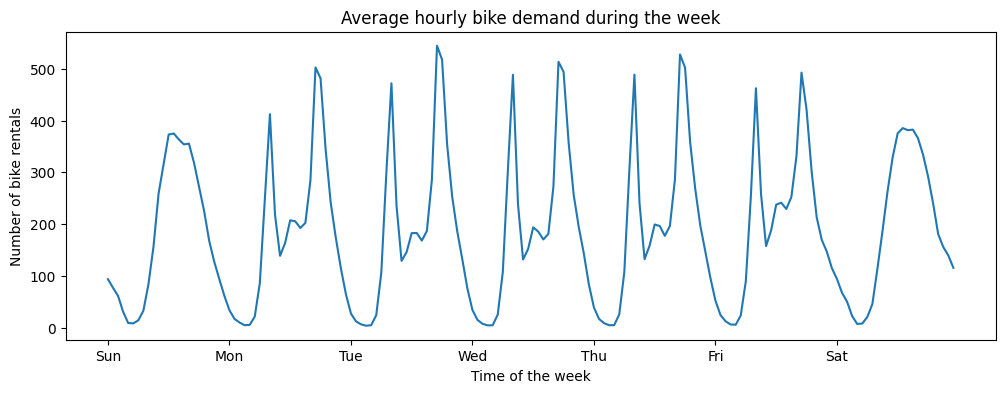

In [17]:
fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df.groupby(["weekday", "hour"])["count"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

The target of the prediction problem is the absolute count of bike rentals on a hourly basis:

In [18]:
df["count"].max()

977

The target variable (number of hourly bicycle rentals) is rescaled to predict relative demand so that the mean absolute error can be more easily interpreted as a fraction of the maximum demand.

In [19]:
df["count"] = df["count"] / df["count"].max()

Note:
The fitting method of the models used in this notebook minimizes the mean squared error to estimate the conditional mean, rather than the mean absolute error that would fit an estimator of the conditional median.
When we report power measurement on the test set in the discussion, we focus instead on the mean absolute error, which is more intuitive than the root mean square error.
Note, however, that in this study the best models for one metric are also the best for the other.

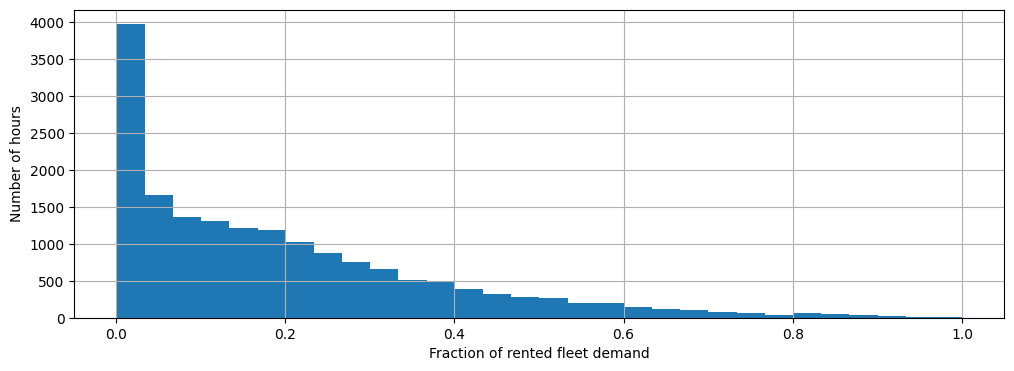

In [20]:
fig, ax = plt.subplots(figsize=(12, 4))
df["count"].hist(bins=30, ax=ax)
_ = ax.set(
    xlabel="Fraction of rented fleet demand",
    ylabel="Number of hours",
)

The input data frame is a timed hourly log of variables describing weather conditions. It contains both numeric and categorical variables.
Note that the time information has already been expanded into several supplemental columns.

In [21]:
from spotRiver.data.bike_sharing import get_bike_sharing_data
df, train, test = get_bike_sharing_data()

In [22]:
df.describe(include="all")

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
count,17379,17379.000000,17379.000000,17379.000000,17379,17379.000000,17379,17379,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
unique,4,NaN,NaN,NaN,2,NaN,2,3,NaN,NaN,NaN,NaN,NaN
top,fall,NaN,NaN,NaN,False,NaN,True,clear,NaN,NaN,NaN,NaN,NaN
freq,4496,NaN,NaN,NaN,16879,NaN,11865,11413,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.502561,6.537775,11.546752,NaN,3.003683,NaN,NaN,20.376474,23.788755,0.627229,12.736540,0.193923
std,NaN,0.500008,3.438776,6.914405,NaN,2.005771,NaN,NaN,7.894801,8.592511,0.192930,8.196795,0.185658
min,NaN,0.000000,1.000000,0.000000,NaN,0.000000,NaN,NaN,0.820000,0.000000,0.000000,0.000000,0.001024
25%,NaN,0.000000,4.000000,6.000000,NaN,1.000000,NaN,NaN,13.940000,16.665000,0.480000,7.001500,0.040942
50%,NaN,1.000000,7.000000,12.000000,NaN,3.000000,NaN,NaN,20.500000,24.240000,0.630000,12.998000,0.145343
75%,NaN,1.000000,10.000000,18.000000,NaN,5.000000,NaN,NaN,27.060000,31.060000,0.780000,16.997900,0.287615


In [ ]:
# save the dataframe to a csv file
df.to_csv("bike_sharing_demand_sklearn.csv", index=False)



In [26]:
df["weather"].value_counts()

weather
clear    11413
misty     4544
rain      1422
Name: count, dtype: int64

In [27]:
df["season"].value_counts()

season
fall      4496
summer    4409
spring    4242
winter    4232
Name: count, dtype: int64

In [28]:
from spotRiver.plot.stats import corrplot
corrplot(df)

,year,month,hour,weekday,temp,feel_temp,humidity,windspeed,count
year,nan,nan,nan,nan,nan,nan,nan,nan,nan
month,-0.010473,nan,nan,nan,nan,nan,nan,nan,nan
hour,-0.003867,-0.005772,nan,nan,nan,nan,nan,nan,nan
weekday,-0.004485,0.010400,-0.003498,nan,nan,nan,nan,nan,nan
temp,0.040913,0.201691,0.137603,-0.001795,nan,nan,nan,nan,nan
feel_temp,0.039222,0.208096,0.133750,-0.008821,0.987672,nan,nan,nan,nan
humidity,-0.083546,0.164411,-0.276498,-0.037158,-0.069881,-0.051918,nan,nan,nan
windspeed,-0.008740,-0.135386,0.137252,0.011502,-0.023125,-0.062336,-0.290105,nan,nan
count,0.250495,0.120638,0.394071,0.026900,0.404772,0.400929,-0.322911,0.093234,nan
